In [1]:
import sys
sys.path.append('../')
from read_data_functions import *
from plot_functions import *
from calculations import *
plt.style.use('../Style.mplstyle')
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # suppress warnings

In [2]:
path = '../../../Data/2025/250929-251003_Ulva/PTR-MS'
data = import_PTRMS(path, '')
dict_keys = ['Traces_P002_Conc', 'Traces_P07_Conc', 'Traces_P39_Conc', 'Traces_P19_Conc', 'Traces_Blank_Conc']

timestamps = [[['2025-09-30 12:54', '2025-09-30 14:38'],
               ['2025-10-02 17:06', '2025-10-02 18:57']],   # [P] = 0.02 uM
              [['2025-10-01 16:02', '2025-10-01 17:49'],
               ['2025-10-03 10:15', '2025-10-03 12:03']],   # [P] = 0.7 uM
              [['2025-09-29 17:25', '2025-09-29 19:11'],
               ['2025-10-01 09:47', '2025-10-01 11:31'],
               ['2025-10-02 13:38', '2025-10-02 15:27']],   # [P] = 3.9 uM
              [['2025-09-30 16:29', '2025-09-30 18:14'],     
               ['2025-10-02 10:06', '2025-10-02 12:06'],
               ['2025-10-03 13:32', '2025-10-03 15:17']],   # [P] = 19 uM
              [['2025-09-30 09:44', '2025-09-30 11:34'],
               ['2025-10-01 12:58', '2025-10-01 14:46'],
               ['2025-10-03 17:13', '2025-10-03 18:59']]]   # Blank   

for key in dict_keys[1:]:
    data[key]['m137.132 (C[12]10H[1]17) (Conc)'] = data[key]['m137.132 (C[12]10H[1]17) (Conc)'] + data[key]['m81.070 (C[12]6H[1]9) (Conc)']
    data[key] = data[key].drop(columns = ['m81.070 (C[12]6H[1]9) (Conc)'])
    if 'P39' not in key:
        data[key]['m135.116 (C[12]10H[1]15) (Conc)'] = data[key]['m135.116 (C[12]10H[1]15) (Conc)'] + data[key]['m95.085 (C[12]7H[1]11) (Conc)']
        data[key] = data[key].drop(columns = ['m95.085 (C[12]7H[1]11) (Conc)'])

m63.026 (C[12]2H[1]7S[32]1) (Conc)            1.607465e-06
m105.930 (C[12]1N[14]1Br[79]1H[1]1) (Conc)    7.193525e-07
m153.915 (C[12]1N[14]1I[127]1H[1]1) (Conc)    0.000000e+00
m266.813 (C[12]1I[127]2H[1]1) (Conc)          4.488489e-06
dtype: float64
m63.026 (C[12]2H[1]7S[32]1) (Conc)            1938
m105.930 (C[12]1N[14]1Br[79]1H[1]1) (Conc)     330
m153.915 (C[12]1N[14]1I[127]1H[1]1) (Conc)     698
m266.813 (C[12]1I[127]2H[1]1) (Conc)           447
dtype: int64


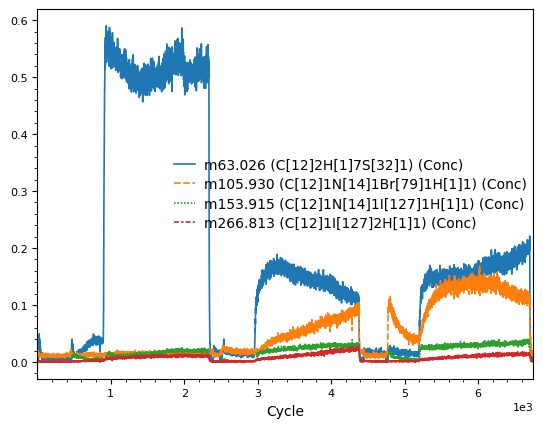

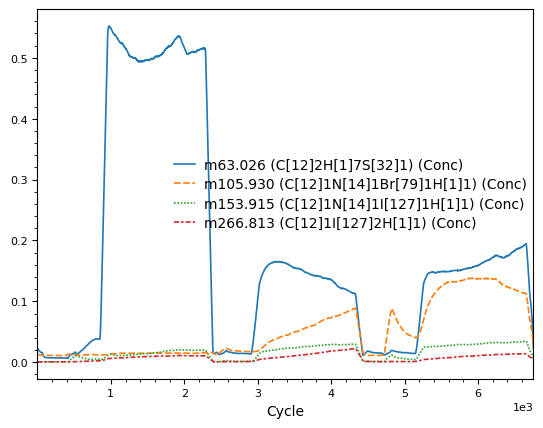

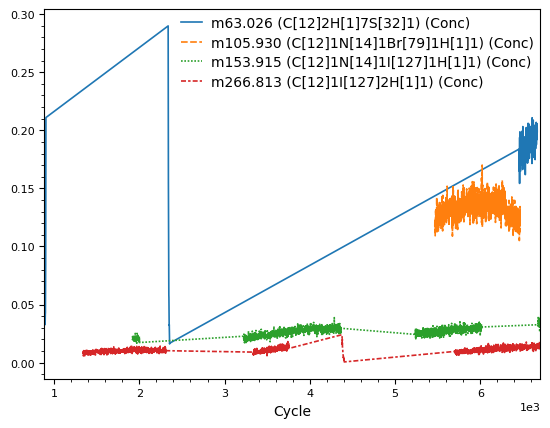

m63.026 (C[12]2H[1]7S[32]1) (Conc)            0.171147
m105.930 (C[12]1N[14]1Br[79]1H[1]1) (Conc)    0.132694
m153.915 (C[12]1N[14]1I[127]1H[1]1) (Conc)    0.026700
m266.813 (C[12]1I[127]2H[1]1) (Conc)          0.010988
dtype: float64


In [3]:
import seaborn as sns

def stable_region_mean(df, window1, window2):
    smooth = df.rolling(window=window1, min_periods=1, center = True).mean()
    df_dx = (smooth.diff().div(smooth.index.to_series().diff(), axis = "index")).dropna()
    df_dx = df_dx.rolling(window=window2, min_periods = 1, center = True).mean()
    df_dx.set_index(smooth.index[:-1])
    
    # Crude std of noise estimation
    std = df.sub(smooth, axis = "index").std()

    # Select most stable cadidates
    """
    most stable candidates is selected on following critiria:
    The longest section of data where the gradient cumsum is close to zero
    How close is defined by the user
    """ 
    # This forces the program to find one "stable" region (which may not be stable)
    # df_dx_norm = (df_dx - df_dx[df_dx.abs() == df_dx.abs().min()].fillna(value = 0)).div(df_dx.max())
    df_dx_norm = df_dx.div(df_dx.abs().max())
    value_close_zero = df_dx_norm[df_dx_norm.abs() == df_dx_norm.abs().min()].sum()
    print(value_close_zero)
    # gradiant close to 0
    dx_0 =  df_dx_norm[(df_dx_norm > value_close_zero-0.01 ) & (df_dx_norm < value_close_zero+0.01)] 
    # Remove possible asymptote to 0
    dx_0 = dx_0[(smooth[1:] > std*4)]

    # Number of detected stable points
    print(pd.notna(dx_0).sum())

    stable_region = df[(smooth - (smooth[pd.notna(dx_0)]).mean()).abs() < 2*std]
    # DEBUG
    sns.lineplot(df)
    plt.show()
    sns.lineplot(smooth)
    plt.show()
    # sns.lineplot(df_dx)
    sns.lineplot(stable_region)
    plt.show()
    # sns.lineplot(dx_0.fillna(value = 1))
    print(stable_region.mean())

    return stable_region.mean()

test_df = data['Traces_P002_Conc'].set_index('Cycle')
test_df = test_df[test_df.keys()[3:-2]]
mean2 = stable_region_mean(test_df, 100, 50)
# display(df_smooth.index.to_series().diff())

In [4]:
# Identified compounds
compounds = [r'C$_{2}$H$_{7}$S$^{+}$', r'CHNBr$^{+}$', r'C$_{9}$H$_{15}^{+}$',
             r'C$_{10}$H$_{15}^{+}$', r'C$_{10}$H$_{17}^{+}$', r'C$_{11}$H$_{19}^{+}$', r'CHNI$^{+}$', r'C$_{10}$H$_{7}$N$_{2}^{+}$',
             r'C$_{9}$H$_{14}$Cl$^{+}$', r'C$_{10}$H$_{16}$Cl$^{+}$', r'C$_{12}$H$_{13}$O$^{+}$', r'C$_{12}$H$_{15}$O$^{+}$', 
             r'C$_{11}$H$_{20}$Cl$^{+}$', r'C$_{10}$H$_{9}$O$_{4}^{+}$', r'CHI$_{2}^{+}$']
mz_values = ['m63.', 'm105.', 'm123.', 'm135.', 'm137.', 'm151.', 'm153.', 'm155.', 'm157.', 'm171.', 'm173.', 'm175.', 'm187.', 'm193.', 'm266.']

# Drymatter content in g
drymatter_content = [[0.2679, 0.3868],              # [P] = 0.02 uM
                     [0.4145, 0.384],               # [P] = 0.7 uM
                     [0.2333, 0.3914, 0.3739],      # [P] = 3.9 uM
                     [0.4601, 0.3736, 0.4165],      # [P] = 19 uM
                     [1, 1, 1]]                     # Blank 

mean_df = pd.DataFrame({'compound': compounds})
std_df = pd.DataFrame({'compound': compounds})
# Mean concentrations for each phosphorous content
for i, key in enumerate(dict_keys):
    idx = []
    for j, mz in enumerate(mz_values):
        for df_key in data[key].keys():
            if mz in df_key:
                idx.append(compounds[j])

    conc_mean, conc_std = exp_mean(data[key], data[key].keys()[4:-2], timestamps[i], drymatter_content[i])
    # concentrations are normalized according to drymatter content of algae used in each experiment
    
    conc_mean = pd.DataFrame({'compound': idx, key.split('_')[1]: conc_mean})
    conc_std = pd.DataFrame({'compound': idx, key.split('_')[1]: conc_std})

    mean_df = pd.merge(mean_df, conc_mean, how = 'outer', on = 'compound')
    std_df = pd.merge(std_df, conc_std, how = 'outer', on = 'compound')

for key in mean_df.keys()[1:-1]:
    mean_df[key] = mean_df[key] - mean_df['Blank']
    std_df[key] = std_df[key] - std_df['Blank']

mean_df, std_df = mean_df.set_index(mean_df['compound']), std_df.set_index(std_df['compound'])
mean_df, std_df = mean_df.drop(columns = ['compound', 'Blank']), std_df.drop(columns = ['compound', 'Blank'])

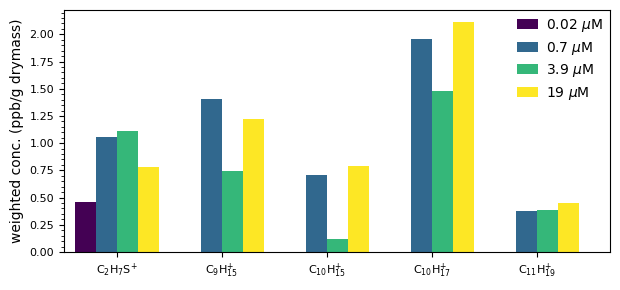

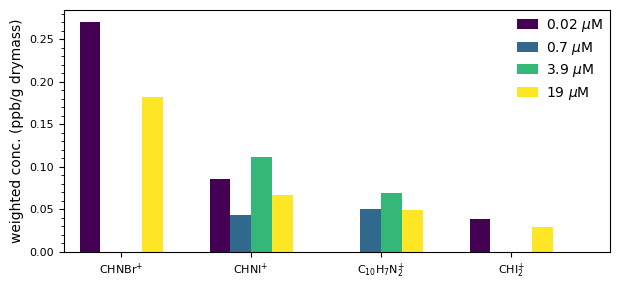

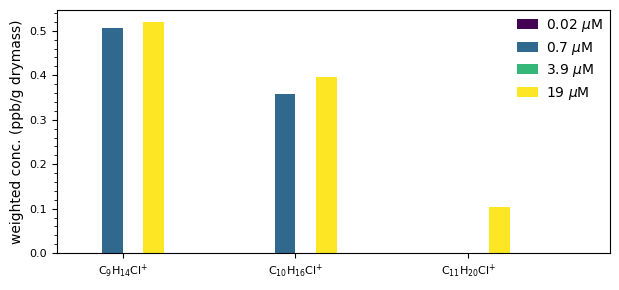

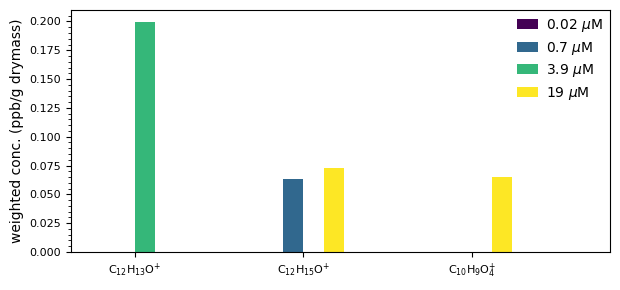

In [5]:
file_names = ['DMS+monoterpenes.jpg', 'halogenated+nitrogenated.jpg', 'chlorinated.jpg', 'oxygenated.jpg']
P_conc = [r'0.02 $\mu$M', r'0.7 $\mu$M', r'3.9 $\mu$M', r'19 $\mu$M']
compounds_rearanged = [[compounds[0]] + compounds[2:6],
                       [compounds[1], compounds[6], compounds[7], compounds[-1]],
                       [compounds[8], compounds[9], compounds[12]],
                       [compounds[10], compounds[11], compounds[13]]]
n_lines = len(P_conc)
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_lines))

for name, compound in zip(file_names, compounds_rearanged):
    x_values = np.arange(len(compound))
    width = len(compound)/25
    multiplier = 0

    fig, ax = plt.subplots(figsize = (6.3, 3))
    df = mean_df.loc[compound].T.reset_index(drop = True)
    for idx, row in df.iterrows():
        offset = width * multiplier
        rects = ax.bar(x_values+offset, row, width, color = colors[idx])    #, yerr = std_df.T[idx])
        multiplier += 1
    ax.set_xlim(-0.2, len(compound))
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.set_xticks(x_values+1.5*width, compound)
    ax.set(ylabel = 'weighted conc. (ppb/g drymass)')
    ax.legend(labels = P_conc, loc = 1)

    fig.tight_layout()
    fig.savefig(name, dpi = 600)